## Style Transfer Using GAN (CycleGAN)

### Variables, Hyperparamaters and libraries import

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# PLATFORM = 'collab'
PLATFORM = 'kaggle'
# PLATFORM = ''

In [7]:
# %pip install -r requirements.txt
# %pip install git+https://github.com/tensorflow/docs

In [8]:
import os 
import time
import glob
import pickle
import imageio
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import asarray
from skimage.io import imread 

import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow_docs.vis.embed as embed
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import img_to_array, load_img, array_to_img

In [9]:
if PLATFORM == 'collab':
    SOURCE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/projects/Style-Transfer-using-GAN/Source/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'
elif PLATFORM == 'kaggle':
    SOURCE_FOLDER = '/kaggle/input/cyclegan-dataset/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'
else:
    SOURCE_FOLDER = './Source/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'

# TIMESTAMP = str(time.strftime('%Y%m%d%H%M%S'))  
TIMESTAMP = '20250509110606'
restore_checkpoint = False
TEMP_FOLDER = OUTPUT_FOLDER + TIMESTAMP + '/'

if os.path.exists(OUTPUT_FOLDER):
    if os.path.exists(TEMP_FOLDER) != True:
        os.mkdir(TEMP_FOLDER)
else:
    os.mkdir(OUTPUT_FOLDER)
    os.mkdir(TEMP_FOLDER)

EPOCHS = 50
BATCH_SIZE = 1 
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 1000

### Data Initialization

I0000 00:00:1746791118.094154      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


(43, 256, 256, 1)
(46, 256, 256, 1)


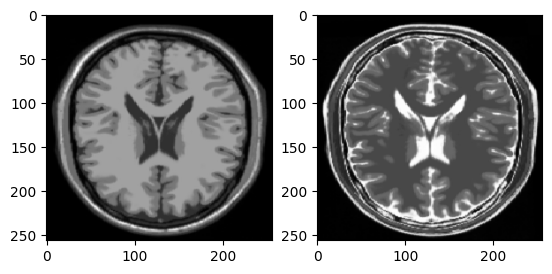

In [10]:
# load and resize images
def load_images(path, size=(IMG_HEIGHT, IMG_WIDTH)):
    images = glob.glob(path+'*.png')
    data_list = list()

    for filename in images:
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)

t1_images = load_images(T1_FOLDER)
t2_images = load_images(T2_FOLDER)

tr1_data = tf.image.rgb_to_grayscale(t1_images)
tr2_data = tf.image.rgb_to_grayscale(t2_images)

print(tr1_data.shape)
print(tr2_data.shape)

tr1_dt= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr2_dt= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))

fig, axs = plt.subplots(1,2)
axs[0].imshow(tr1_data[0], cmap='gray')
axs[1].imshow(tr2_data[0], cmap='gray')
plt.show();

### Image Preprocessing

In [11]:
# t1_images = np.zeros((t1_df.shape[0], IMG_HEIGHT, IMG_WIDTH))
# t2_images = np.zeros((t2_df.shape[0], IMG_HEIGHT, IMG_WIDTH))

# for idx, img in enumerate(t1_df['img_pxl']):
#     t1_images[idx, :, :] = resize(img, (IMG_HEIGHT, IMG_WIDTH))

# for idx, img in enumerate(t2_df['img_pxl']):
#     t2_images[idx, :, :] = resize(img, (IMG_HEIGHT, IMG_WIDTH))

# t1_images.shape    
# t2_images.shape

# t1_images = (t1_images/127.5)-1.0
# t2_images = (t2_images/127.5)-1.0

# t1_images = t1_images.reshape(t1_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')
# t2_images = t2_images.reshape(t2_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')

# t1_img_data = tf.data.Dataset.from_tensor_slices(t1_images).shuffle(t1_images.shape[0], seed=42).batch(BATCH_SIZE)
# t2_img_data = tf.data.Dataset.from_tensor_slices(t2_images).shuffle(t2_images.shape[0], seed=42).batch(BATCH_SIZE)

#### Image Normalization, Shuffling and Batch Processing

In [12]:
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1
    return image

def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
# tr1 = tr1_dt.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# tr2 = tr2_dt.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tr1 = tr1_dt.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2_dt.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

sample_t1_data = next(iter(tr1))
sample_t2_data = next(iter(tr2))

#### Augmentation Tryouts

In [13]:
# #Simulates thermal/electronic noise in scanners
# def add_gaussian_noise(image, mean=0.0, stddev=15.0):
#     noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
#     noisy_image = tf.clip_by_value(image + noise, 0.0, 255.0)
#     return noisy_image

# # Mimics scanner calibration issues
# def intensity_shift(image, shift_range=30):
#     shift = tf.random.uniform([], -shift_range, shift_range, dtype=tf.float32)
#     shifted_image = image + shift
#     return tf.clip_by_value(shifted_image, 0.0, 255.0)


# #Simulates non-uniform magnetic field causing smooth illumination bias
# def intensity_gradient(image):
#     height, width, _ = image.shape
#     gradient = tf.linspace(0.8, 1.2, width)
#     gradient = tf.reshape(gradient, (1, width, 1))
#     biased_image = image * gradient
#     return tf.clip_by_value(biased_image, 0.0, 255.0)

# #MRI scans from different scanners may have varying contrast levels
# def random_contrast(image, lower=0.7, upper=1.3):
#     # Contrast variation in the range [0, 255]
#     contrast_factor = tf.random.uniform([], lower, upper)
#     contrast_image = image * contrast_factor
#     return tf.clip_by_value(contrast_image, 0.0, 255.0)

In [14]:
# # Visualize all
# fig, axs = plt.subplots(2, 5, figsize=(20, 5))

# axs[0][0].imshow(tr1_data[0], cmap="gray")  # Original
# axs[0][0].set_title('Original T1')
# axs[0][1].imshow(add_gaussian_noise(tr1_data[0]), cmap="gray")
# axs[0][1].set_title('Gaussian Noise')
# axs[0][2].imshow(intensity_gradient(tr1_data[0]), cmap="gray")
# axs[0][2].set_title('Biased Magnetic Field')
# axs[0][3].imshow(random_contrast(tr1_data[0]), cmap="gray")
# axs[0][3].set_title('Randomized Contrast')
# axs[0][4].imshow(intensity_shift(tr1_data[0]), cmap="gray")
# axs[0][4].set_title('Intensity Shift')
# axs[1][0].imshow(tr2_data[0], cmap="gray")  # Original
# axs[1][0].set_title('Original T2')
# axs[1][1].imshow(add_gaussian_noise(tr2_data[0]), cmap="gray")
# axs[1][1].set_title('Gaussian Noise')
# axs[1][2].imshow(intensity_gradient(tr2_data[0]), cmap="gray")
# axs[1][2].set_title('Biased Magnetic Field')
# axs[1][3].imshow(random_contrast(tr2_data[0]), cmap="gray")
# axs[1][3].set_title('Randomized Contrast')
# axs[1][4].imshow(intensity_shift(tr2_data[0]), cmap="gray")
# axs[1][4].set_title('Intensity Shift')

# for ax in axs:
#     for a in ax:
#         a.axis('off')

# plt.show();

In [15]:
# seed = (1, 2)
# fig, axs = plt.subplots(1,4)

# axs[0].imshow(array_to_img(t1_images[0]), cmap='gray')
# axs[1].imshow(tf.image.adjust_brightness(array_to_img(t1_images[0]), delta=0.5))
# axs[2].imshow(tf.image.stateless_random_brightness(array_to_img(t1_images[0]),0.2,seed = (1, 2)), cmap='gray')
# axs[3].imshow(array_to_img(t2_images[0]), cmap='gray')
# plt.show();

### Loss Functions & Optimizer 

In [16]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Model Building

#### Instance Normalization

In [17]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__() # calling parent's init
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling and Upsampling

In [18]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
        
    # Add Leaky Relu Activation 
    # result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    # Add Normalization Layer
    result.add(InstanceNormalization())
    
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator

In [19]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    
    down_stack = [
        downsample(64, 4, True),
        downsample(128, 4, True),
        downsample(256, 4, True),
        
        # downsample(512, 4),
        # downsample(512, 4),
        # downsample(512, 4),
        # downsample(512, 4)
        
        # downsample(64, 4, False), # (bs, 16, 16, 64)
        # downsample(128, 4), # (bs, 8, 8, 128)
        # downsample(128, 4), # (bs, 4, 4, 128)
        # downsample(128, 4), # (bs, 2, 2, 128)
        # downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(256, 4, False),
        upsample(128, 4, False),
        upsample(64, 4, False)
        
        # upsample(512, 4, True),
        # upsample(512, 4, True),
        # upsample(512, 4),

        # upsample(128, 4, True), # (bs, 2, 2, 256)
        # upsample(128, 4, True), # (bs, 4, 4, 256)
        # upsample(128, 4), # (bs, 8, 8, 256)
        # upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
generator_g = unet_generator()
generator_f = unet_generator()

generator_g.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          1,152 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,328 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        524,800 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 64, 64, 256)    │      1,049,088 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 192)  │              0 │ sequential_3[0][0],    │
│                           │                        │                │ sequential_1[0][0],    │
│                           │                        │                │ sequential_4[0][0],    │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 128, 128, 128)  │        786,688 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 256, 256, 1)    │          3,073 │ concatenate[1][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,496,129 (9.52 MB)

 Trainable params: 2,496,129 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [21]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(256, 4)(down2)
    
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) 
    # conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
    #                               use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [22]:
discriminator_x = discriminator()
discriminator_y = discriminator()

discriminator_x.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 128, 128, 64)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 64, 64, 128)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 32, 32, 256)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_14            │ (None, 31, 31, 512)         │           1,024 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,521 (10.54 MB)

 Trainable params: 2,763,521 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1746791119.495632      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


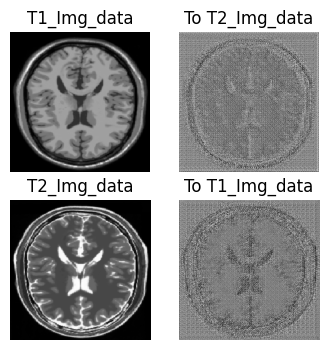

In [23]:
to_t2_img_data = generator_g(sample_t1_data)
to_t1_img_data = generator_f(sample_t2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_t1_data, to_t2_img_data, sample_t2_data, to_t1_img_data]
title = ['T1_Img_data', 'To T2_Img_data', 'T2_Img_data', 'To T1_Img_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
plt.show();

### Model Training

#### Checkpoint Initialization

In [24]:
checkpoint_path = TEMP_FOLDER +"Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint and restore_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [25]:
def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(TEMP_FOLDER +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show();

In [26]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_id_loss = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return {
        'gen_g_loss': gen_g_loss, 'gen_f_loss': gen_f_loss,
        'cycle_loss': total_cycle_loss, 'identity_loss': total_id_loss,
        'disc_x_loss': disc_x_loss, 'disc_y_loss': disc_y_loss
    }

In [27]:
# for epoch in range(1, EPOCHS+1):
#     for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
#         train_step(image_x, image_y)
#     generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data, epoch)
#     ckpt_save_path = ckpt_manager.save()
#     print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)


Epoch 1/50
Avg Losses -> GenG: 1.1241, GenF: 1.1291, Cycle: 3.7552, Identity: 0.3551, DiscX: 0.6220, DiscY: 0.6600


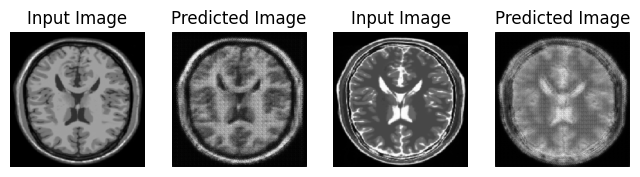

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-1

Epoch 2/50
Avg Losses -> GenG: 1.0681, GenF: 1.0701, Cycle: 1.8654, Identity: 0.1498, DiscX: 0.6287, DiscY: 0.5633


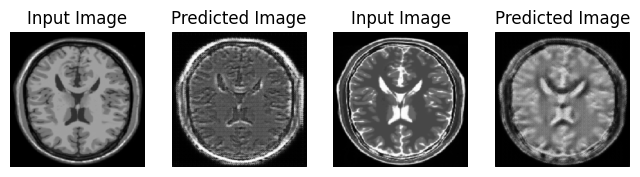

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-2

Epoch 3/50
Avg Losses -> GenG: 1.0690, GenF: 0.9914, Cycle: 1.8830, Identity: 0.1536, DiscX: 0.5899, DiscY: 0.5593


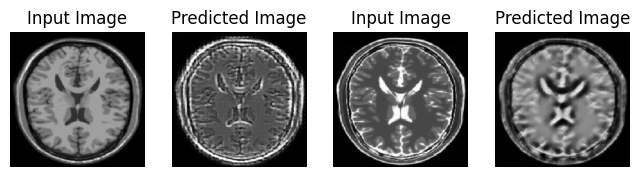

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-3

Epoch 4/50
Avg Losses -> GenG: 1.1138, GenF: 1.0391, Cycle: 1.6869, Identity: 0.1484, DiscX: 0.5763, DiscY: 0.5260


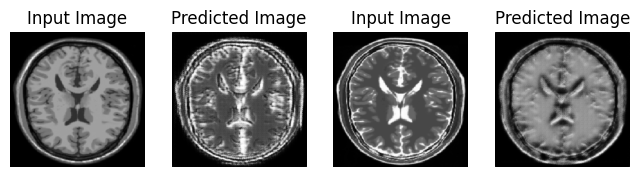

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-4

Epoch 5/50
Avg Losses -> GenG: 1.0188, GenF: 0.9791, Cycle: 1.7070, Identity: 0.1711, DiscX: 0.5988, DiscY: 0.5864


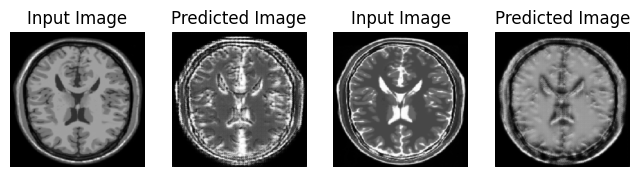

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-5

Epoch 6/50
Avg Losses -> GenG: 1.0349, GenF: 0.9576, Cycle: 1.6506, Identity: 0.1666, DiscX: 0.5881, DiscY: 0.5743


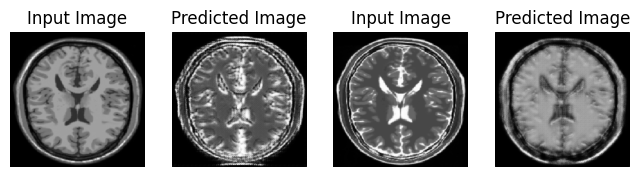

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-6

Epoch 7/50
Avg Losses -> GenG: 1.0298, GenF: 1.0119, Cycle: 1.5671, Identity: 0.1597, DiscX: 0.6025, DiscY: 0.5600


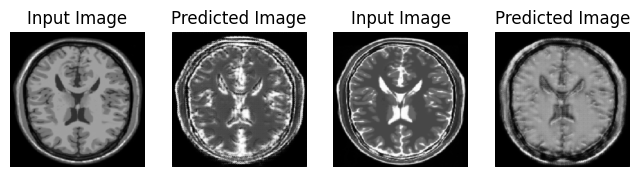

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-7

Epoch 8/50
Avg Losses -> GenG: 1.0577, GenF: 0.9951, Cycle: 1.5623, Identity: 0.1550, DiscX: 0.5786, DiscY: 0.5720


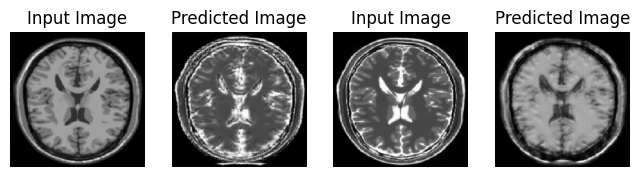

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-8

Epoch 9/50
Avg Losses -> GenG: 1.3955, GenF: 1.0029, Cycle: 1.5653, Identity: 0.1593, DiscX: 0.5661, DiscY: 0.4866


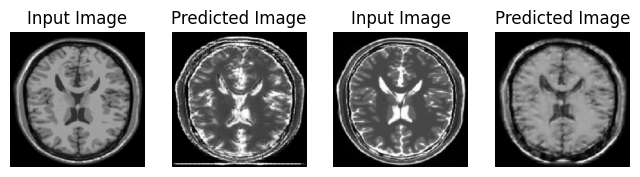

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-9

Epoch 10/50
Avg Losses -> GenG: 1.3570, GenF: 1.0011, Cycle: 1.5152, Identity: 0.1578, DiscX: 0.5772, DiscY: 0.5607


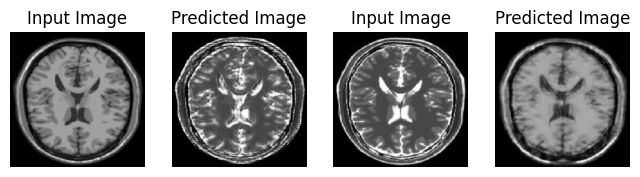

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-10

Epoch 11/50
Avg Losses -> GenG: 1.6147, GenF: 0.9987, Cycle: 1.4867, Identity: 0.1495, DiscX: 0.5620, DiscY: 0.4583


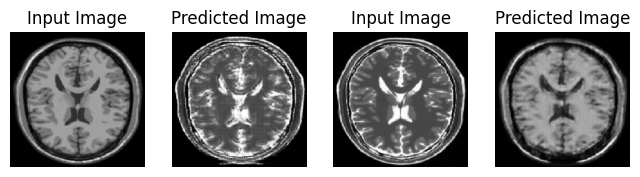

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-11

Epoch 12/50
Avg Losses -> GenG: 1.8804, GenF: 1.0511, Cycle: 1.5968, Identity: 0.1544, DiscX: 0.6295, DiscY: 0.3277


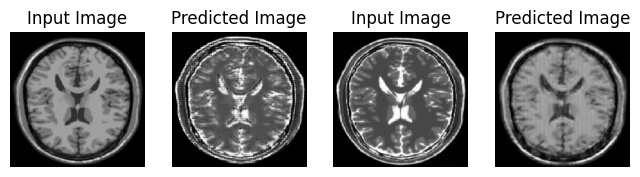

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-12

Epoch 13/50
Avg Losses -> GenG: 2.4116, GenF: 1.1052, Cycle: 1.6936, Identity: 0.1640, DiscX: 0.5351, DiscY: 0.2503


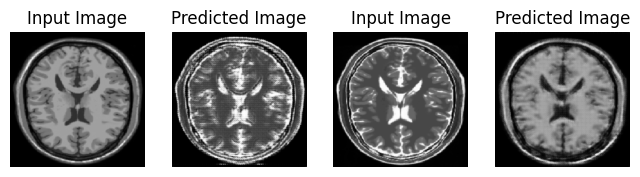

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-13

Epoch 14/50
Avg Losses -> GenG: 1.6728, GenF: 1.1139, Cycle: 1.5037, Identity: 0.1630, DiscX: 0.5571, DiscY: 0.5023


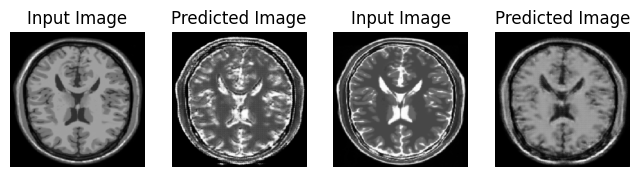

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-14

Epoch 15/50
Avg Losses -> GenG: 1.9945, GenF: 1.2401, Cycle: 1.5459, Identity: 0.1602, DiscX: 0.5308, DiscY: 0.3983


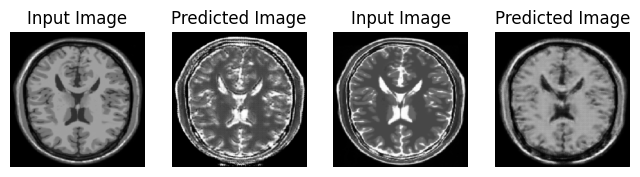

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-15

Epoch 16/50
Avg Losses -> GenG: 1.4764, GenF: 1.3348, Cycle: 1.5359, Identity: 0.1642, DiscX: 0.5023, DiscY: 0.5233


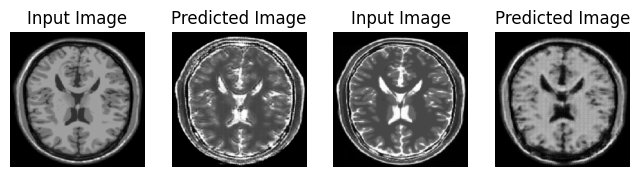

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-16

Epoch 17/50
Avg Losses -> GenG: 1.8669, GenF: 1.3146, Cycle: 1.6051, Identity: 0.1662, DiscX: 0.5189, DiscY: 0.3463


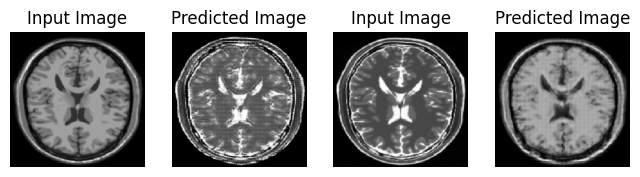

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-17

Epoch 18/50
Avg Losses -> GenG: 1.4049, GenF: 1.1485, Cycle: 1.4469, Identity: 0.1607, DiscX: 0.6226, DiscY: 0.5769


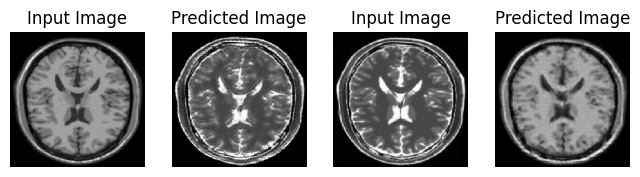

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-18

Epoch 19/50
Avg Losses -> GenG: 1.3395, GenF: 1.4413, Cycle: 1.4927, Identity: 0.1650, DiscX: 0.4653, DiscY: 0.5119


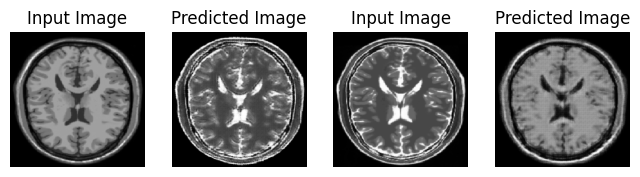

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-19

Epoch 20/50
Avg Losses -> GenG: 1.8603, GenF: 1.8002, Cycle: 1.5997, Identity: 0.1760, DiscX: 0.5006, DiscY: 0.3641


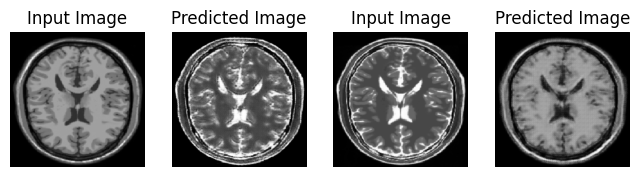

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-20

Epoch 21/50
Avg Losses -> GenG: 1.7885, GenF: 0.9658, Cycle: 1.4291, Identity: 0.1644, DiscX: 0.5979, DiscY: 0.4032


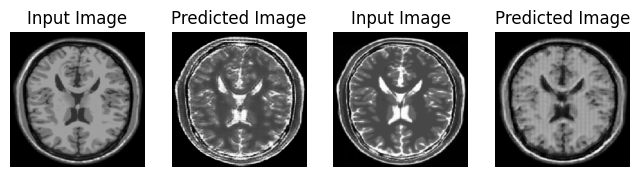

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-21

Epoch 22/50
Avg Losses -> GenG: 1.9427, GenF: 1.2835, Cycle: 1.4676, Identity: 0.1685, DiscX: 0.5443, DiscY: 0.3814


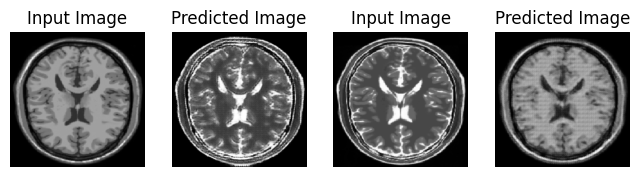

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-22

Epoch 23/50
Avg Losses -> GenG: 2.4351, GenF: 1.3804, Cycle: 1.5040, Identity: 0.1739, DiscX: 0.5078, DiscY: 0.3252


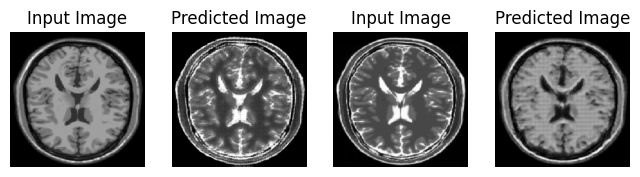

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-23

Epoch 24/50
Avg Losses -> GenG: 2.0790, GenF: 1.8619, Cycle: 1.5451, Identity: 0.1752, DiscX: 0.3982, DiscY: 0.3671


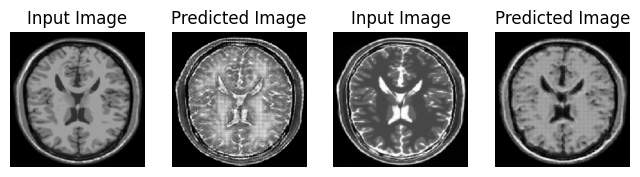

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-24

Epoch 25/50
Avg Losses -> GenG: 2.2590, GenF: 1.6026, Cycle: 1.5540, Identity: 0.1758, DiscX: 0.5775, DiscY: 0.3573


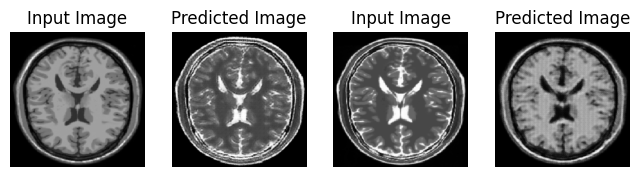

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-25

Epoch 26/50
Avg Losses -> GenG: 3.2711, GenF: 1.2651, Cycle: 1.6534, Identity: 0.1922, DiscX: 0.6259, DiscY: 0.1820


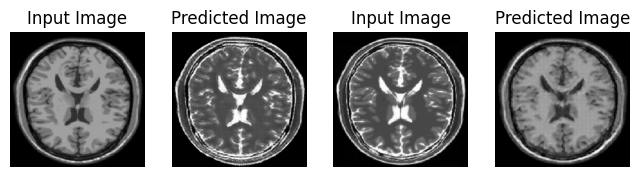

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-26

Epoch 27/50
Avg Losses -> GenG: 2.5012, GenF: 0.8170, Cycle: 1.4055, Identity: 0.1793, DiscX: 0.6535, DiscY: 0.3167


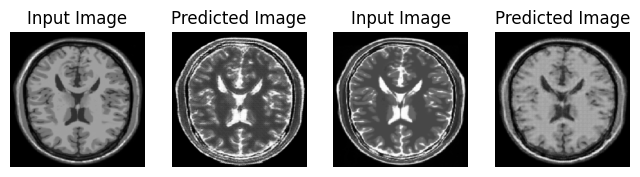

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-27

Epoch 28/50
Avg Losses -> GenG: 2.7039, GenF: 0.9965, Cycle: 1.3738, Identity: 0.1703, DiscX: 0.5692, DiscY: 0.2537


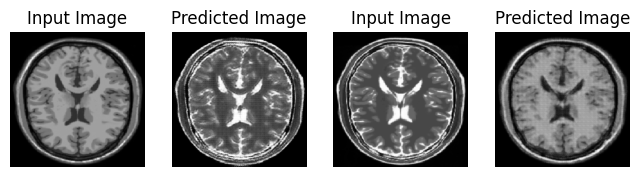

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-28

Epoch 29/50
Avg Losses -> GenG: 2.0780, GenF: 1.9738, Cycle: 1.4828, Identity: 0.1839, DiscX: 0.3582, DiscY: 0.4622


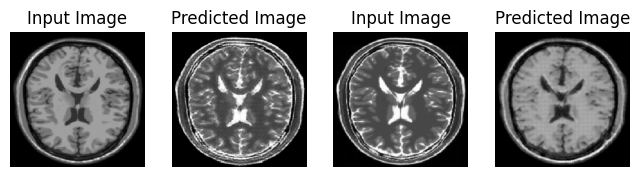

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-29

Epoch 30/50
Avg Losses -> GenG: 3.3131, GenF: 1.5824, Cycle: 1.7583, Identity: 0.1932, DiscX: 0.5719, DiscY: 0.1620


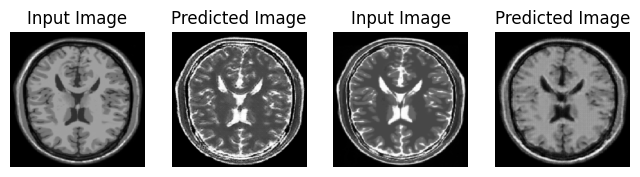

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-30

Epoch 31/50
Avg Losses -> GenG: 2.9746, GenF: 1.7947, Cycle: 1.5952, Identity: 0.1887, DiscX: 0.4099, DiscY: 0.2670


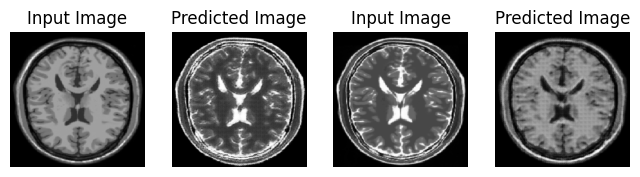

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-31

Epoch 32/50
Avg Losses -> GenG: 2.4594, GenF: 1.8496, Cycle: 1.5042, Identity: 0.1878, DiscX: 0.3664, DiscY: 0.3602


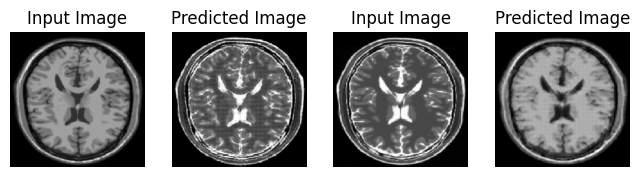

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-32

Epoch 33/50
Avg Losses -> GenG: 2.3004, GenF: 2.0639, Cycle: 1.4928, Identity: 0.1876, DiscX: 0.4053, DiscY: 0.3671


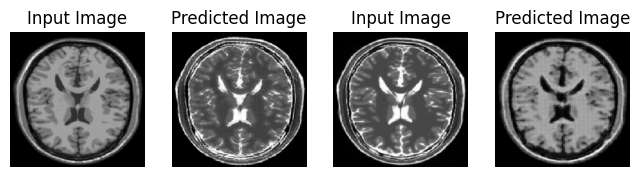

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-33

Epoch 34/50
Avg Losses -> GenG: 2.6509, GenF: 1.3584, Cycle: 1.4775, Identity: 0.1809, DiscX: 0.6326, DiscY: 0.2917


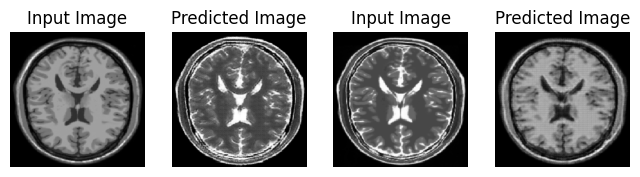

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-34

Epoch 35/50
Avg Losses -> GenG: 2.7619, GenF: 1.7293, Cycle: 1.4114, Identity: 0.1772, DiscX: 0.4422, DiscY: 0.3020


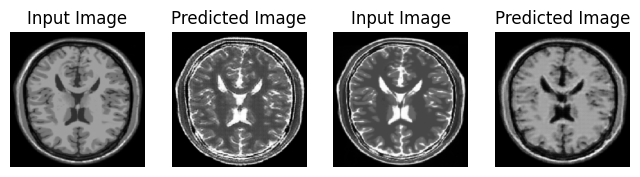

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-35

Epoch 36/50
Avg Losses -> GenG: 2.9366, GenF: 2.2278, Cycle: 1.4982, Identity: 0.1906, DiscX: 0.3147, DiscY: 0.2433


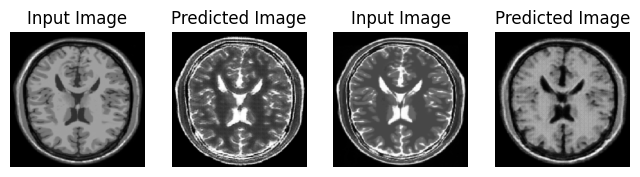

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-36

Epoch 37/50
Avg Losses -> GenG: 2.8843, GenF: 2.0536, Cycle: 1.6603, Identity: 0.1838, DiscX: 0.4805, DiscY: 0.3293


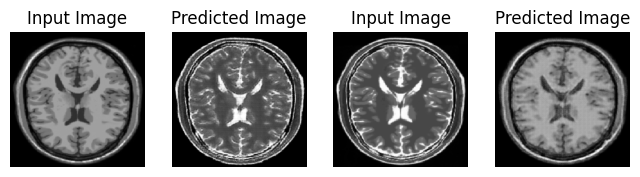

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-37

Epoch 38/50
Avg Losses -> GenG: 2.3322, GenF: 0.8351, Cycle: 1.2611, Identity: 0.1654, DiscX: 0.6508, DiscY: 0.3912


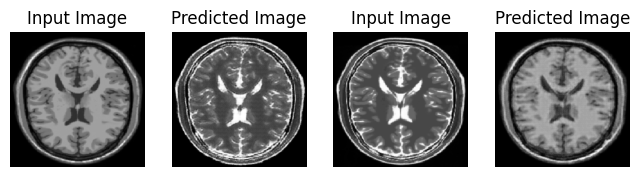

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-38

Epoch 39/50
Avg Losses -> GenG: 1.9657, GenF: 0.8396, Cycle: 1.2122, Identity: 0.1558, DiscX: 0.6291, DiscY: 0.4226


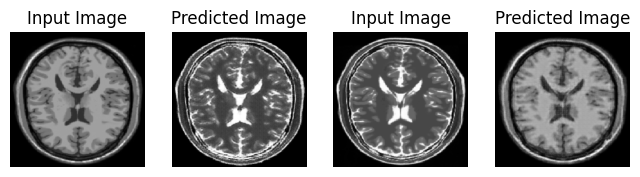

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-39

Epoch 40/50
Avg Losses -> GenG: 2.3322, GenF: 0.8890, Cycle: 1.2708, Identity: 0.1533, DiscX: 0.5973, DiscY: 0.2789


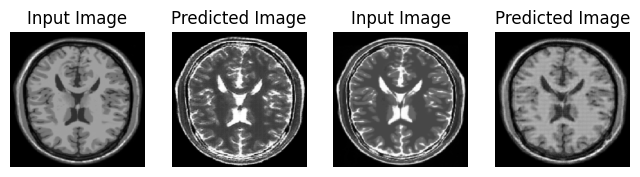

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-40

Epoch 41/50
Avg Losses -> GenG: 2.3508, GenF: 1.0011, Cycle: 1.2358, Identity: 0.1619, DiscX: 0.6756, DiscY: 0.4814


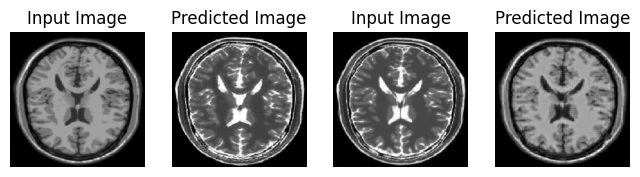

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-41

Epoch 42/50
Avg Losses -> GenG: 2.2218, GenF: 1.5805, Cycle: 1.3277, Identity: 0.1623, DiscX: 0.4650, DiscY: 0.3291


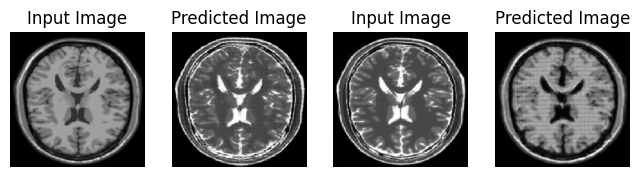

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-42

Epoch 43/50
Avg Losses -> GenG: 3.4583, GenF: 1.6165, Cycle: 1.4779, Identity: 0.1783, DiscX: 0.4256, DiscY: 0.1586


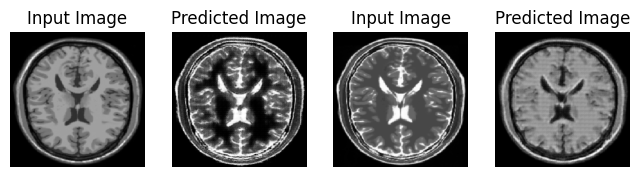

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-43

Epoch 44/50
Avg Losses -> GenG: 4.1773, GenF: 1.8617, Cycle: 1.7755, Identity: 0.1782, DiscX: 0.5790, DiscY: 0.0785


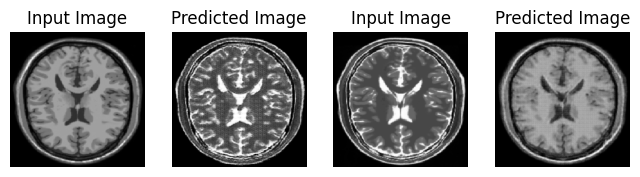

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-44

Epoch 45/50
Avg Losses -> GenG: 2.7693, GenF: 0.7870, Cycle: 1.2666, Identity: 0.1632, DiscX: 0.6727, DiscY: 0.3438


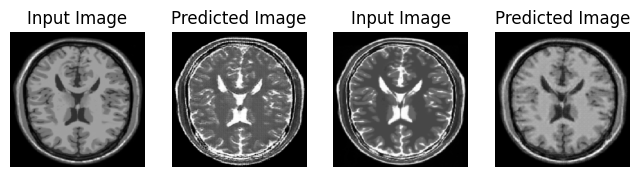

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-45

Epoch 46/50
Avg Losses -> GenG: 3.2080, GenF: 0.8209, Cycle: 1.3161, Identity: 0.1594, DiscX: 0.6157, DiscY: 0.2539


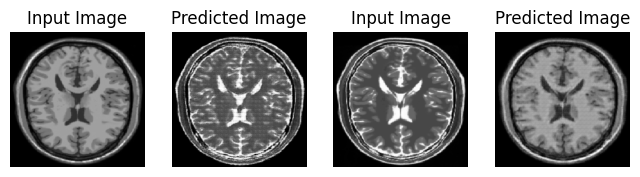

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-46

Epoch 47/50
Avg Losses -> GenG: 3.4188, GenF: 0.9085, Cycle: 1.4406, Identity: 0.1561, DiscX: 0.6005, DiscY: 0.1879


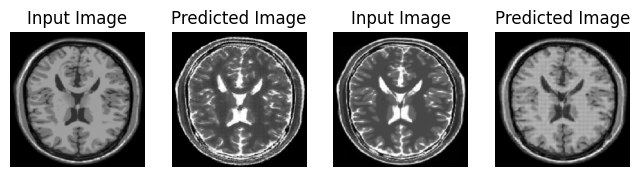

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-47

Epoch 48/50
Avg Losses -> GenG: 3.2135, GenF: 0.8626, Cycle: 1.2954, Identity: 0.1617, DiscX: 0.5961, DiscY: 0.2553


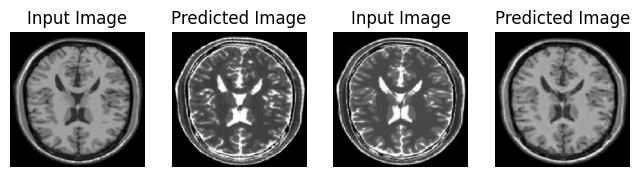

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-48

Epoch 49/50
Avg Losses -> GenG: 3.5932, GenF: 0.8906, Cycle: 1.3198, Identity: 0.1602, DiscX: 0.6147, DiscY: 0.2581


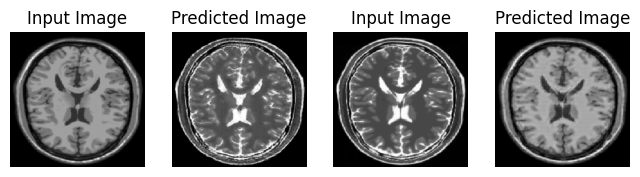

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-49

Epoch 50/50
Avg Losses -> GenG: 2.4741, GenF: 0.9126, Cycle: 1.2408, Identity: 0.1530, DiscX: 0.5938, DiscY: 0.2854


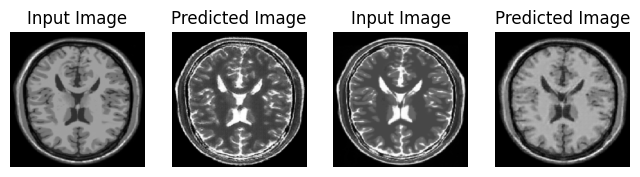

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-50


In [28]:
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    
    total_losses = {
        'gen_g_loss': 0,
        'gen_f_loss': 0,
        'cycle_loss': 0,
        'identity_loss': 0,
        'disc_x_loss': 0,
        'disc_y_loss': 0
    }

    steps = 0
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        losses = train_step(image_x, image_y)
        for key in total_losses:
            total_losses[key] += losses[key]
        steps += 1

    avg_losses = {k: v / steps for k, v in total_losses.items()}
    print(f"Avg Losses -> GenG: {avg_losses['gen_g_loss']:.4f}, GenF: {avg_losses['gen_f_loss']:.4f}, "
          f"Cycle: {avg_losses['cycle_loss']:.4f}, Identity: {avg_losses['identity_loss']:.4f}, "
          f"DiscX: {avg_losses['disc_x_loss']:.4f}, DiscY: {avg_losses['disc_y_loss']:.4f}")

    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data, epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Checkpoint saved at', ckpt_save_path)

### Model Visualization

In [29]:
anim_file = TEMP_FOLDER + 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob( TEMP_FOLDER + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_31/2460268509.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_31/2460268509.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



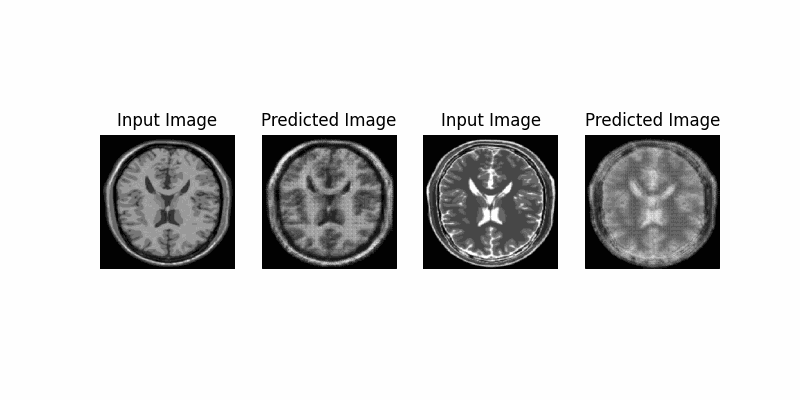

In [30]:
embed.embed_file(anim_file)

### Model Testing

In [31]:
def test_model(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(5, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

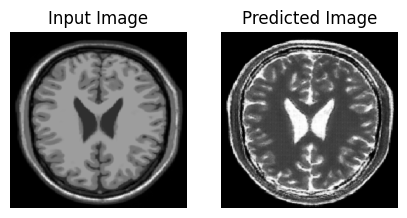

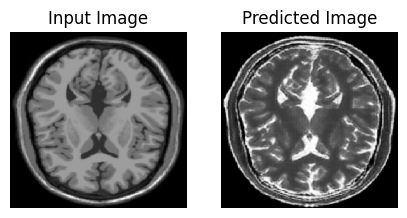

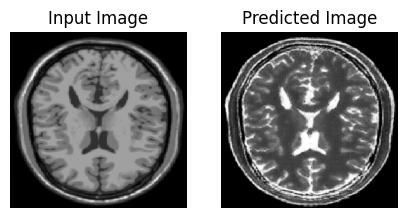

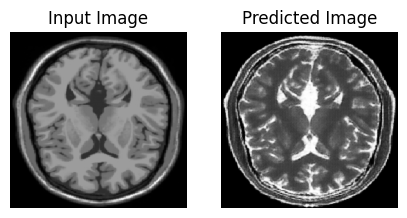

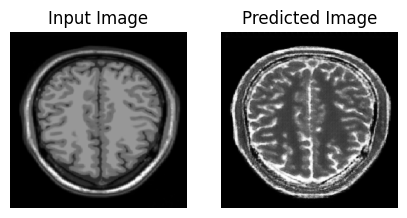

In [32]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    test_model(generator_g, inp)

In [38]:
# %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir ./logs/

tf.saved_model.save( generator_g, './Output')

shutil.make_archive(TIMESTAMP + 'model_output', 'zip', TEMP_FOLDER) 
!rm -rf TEMP_FOLDER

x = tf.saved_model.load('./Output')
dir(generator_g)
generator_g.save('./Output/test.keras')
new_model =   tf.keras.models.load_model('./Output')

'/kaggle/working/Test2_model_output.zip'

In [83]:
generator_g.save('./Output/test.keras')
new_model =   tf.keras.models.load_model('./Output')

ValueError: File format not supported: filepath=./Output. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./Output, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [69]:
print(train_step.pretty_printed_concrete_signatures())

Input Parameters:
  real_x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None)
  real_y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None)
Output Type:
  Dict[['gen_g_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['gen_f_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['cycle_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['identity_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['disc_x_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['disc_y_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)]]
Captures:
  140492411799504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492411799120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492411798736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492411798544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492415986832: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [84]:
tf.keras.models.save_model(generator_g, './Output/test.keras')
tf.keras.models.load_model('./Output/test.keras')

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_5', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 64]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}}], 'build_input_shape': [None, 256, 256, 1]}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}, 'name': 'sequential', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 1], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 128, 128, 64], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'filters': 128, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 64, 64, 128]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}}], 'build_input_shape': [None, 128, 128, 64]}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'sequential_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['sequential', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 64, 64, 128], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'filters': 256, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 32, 32, 256]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}}], 'build_input_shape': [None, 64, 64, 128]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'sequential_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['sequential_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 32, 32, 256], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_4'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'filters': 256, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 64, 64, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}}], 'build_input_shape': [None, 32, 32, 256]}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'sequential_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['sequential_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 128]]}, 'name': 'concatenate', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['sequential_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['sequential_1', 0, 0]}}]], 'kwargs': {}}, {'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['sequential_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['sequential', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 64, 64, 384], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_5'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'filters': 128, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 384]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}}], 'build_input_shape': [None, 64, 64, 384]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 384]}, 'name': 'sequential_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 384], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'filters': 1, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 192]}, 'name': 'conv2d_transpose_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 192], 'dtype': 'float32', 'keras_history': ['concatenate', 1, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['conv2d_transpose_3', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}}.

Exception encountered: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 64]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}}], 'build_input_shape': [None, 256, 256, 1]}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}, 'name': 'sequential', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 1], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {'mask': None}}]}.

Exception encountered: Could not locate class 'InstanceNormalization'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'InstanceNormalization', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140492399956688}}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 64]}}

In [79]:
!wget -O test3.jpg 'https://prod-images-static.radiopaedia.org/images/13655932/ba29d24104918a30130f4003faac71.png'

--2025-05-09 14:39:15--  https://prod-images-static.radiopaedia.org/images/13655932/ba29d24104918a30130f4003faac71.png
Resolving prod-images-static.radiopaedia.org (prod-images-static.radiopaedia.org)... 172.67.21.164, 104.22.36.235, 104.22.37.235, ...
Connecting to prod-images-static.radiopaedia.org (prod-images-static.radiopaedia.org)|172.67.21.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102561 (100K) [image/png]
Saving to: ‘test3.jpg’

test3.jpg           100%[===================>] 100.16K  --.-KB/s    in 0.008s  

2025-05-09 14:39:15 (11.7 MB/s) - ‘test3.jpg’ saved [102561/102561]



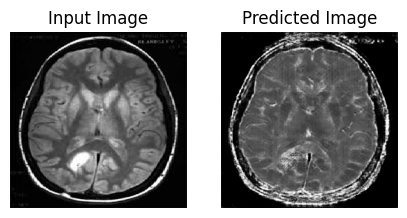

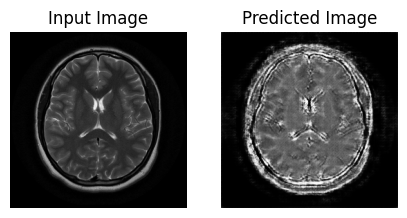

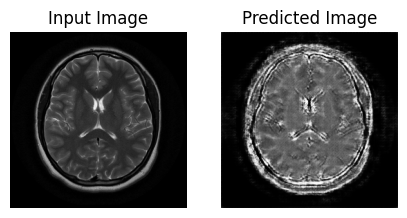

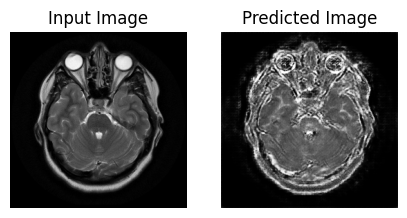

In [80]:
def test_image(img):
    test_image = load_img(img, target_size=(256, 256))
    test_image = img_to_array(test_image) 
    test_image = asarray(test_image)
    test_image = tf.image.rgb_to_grayscale(test_image)
    test_image = tf.expand_dims(test_image, axis=0)
    test= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_image))
    for p in test.take(1):  
        test_model(generator_g, test_image) 

images = ['/kaggle/input/testing/download.jpeg','/kaggle/working/test.jpg','/kaggle/working/test2.jpg','/kaggle/working/test3.jpg']

for img in images:
    test_image(img)